<a href="https://colab.research.google.com/github/chirucodes/aiml/blob/main/automatic_image_captioning/ResNet50_LSTM_with_Attention_ImageCaptioningGroup4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference Links to follow

In [2]:
# Add reference links below

# https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/
# https://rupamgoyal12.medium.com/image-caption-generator-using-resnet50-and-lstm-model-a5b11f60cd23

# 

## Hyper Parameters

In [3]:
HYP_DOWNLOAD_DATASET = True
HYP_MOUNT_GOOGLE = False
HYP_SOURCE_DATA_SET = "F8K" # "F30K" / "COCO123K"
HYP_ENCODER_MODEL = "RESNET50" # VGG16, INCEPTIONV3 , etc
HYP_WORD_EMBEDDING = "GLOVE" # word2vec, etc
HYP_ENABLE_TRACE = False # True
HYP_ENABLE_ATTENTION = True # False
HYP_DECODER_LOSS = 'categorical_crossentropy'
HYP_DECODER_OPTIMIZER = 'adam'
HYP_NO_OF_PICS_PER_BATCH = 30
HYP_EPOCH = 5
HYP_DECODER_LEARNING_RATE = 0.0001


## Import Modules

In [4]:
# To list file in a directory
import glob


# Image preprocessing / converting image into feature vectors
from keras.preprocessing import image
import numpy as np

if HYP_ENCODER_MODEL == "RESNET50":
    from tensorflow.keras.applications.resnet50 import preprocess_input
    from tensorflow.keras.applications.resnet50 import ResNet50

elif HYP_ENCODER_MODEL == "VGG16":
    from keras.applications.vgg16 import preprocess_input
    from keras.applications.vgg16 import VGG16


elif HYP_ENCODER_MODEL == "INCEPTIONV3":
    from tensorflow.keras.applications.inception_v3 import preprocess_input
    from tensorflow.keras.applications.inception_v3 import InceptionV3

else:
    print("Invalid HYP_ENCODER_MODEL")


from keras.models import Model


# Execution time calculation
from time import time


# Creating binary files
from pickle import dump, load


# Text processing
import string


# For joining os path
import os


# LSTM architecture
from keras import Input
from keras.layers import Dropout, Dense, Embedding, LSTM
from keras.layers.merge import add
from keras.models import Model


# For caption generation
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from numpy import array
import matplotlib.pyplot as plt

from google.colab import drive

#############
from keras.layers import Layer
import keras.backend as K

import keras

from tensorflow.keras.utils import plot_model

## Download dataset and unzip

In [5]:
if HYP_MOUNT_GOOGLE:
    drive.mount('/content/drive')
    images = glob.glob("/content/drive/MyDrive/AI ML/AIC Project/datasets/Flicker8k/Images")
    images


#### Flicker 8k

In [6]:
if HYP_DOWNLOAD_DATASET:
    if HYP_SOURCE_DATA_SET == "F8K":
        !rm -rf Flickr8k_Dataset.zip
        !rm -rf Flickr8k_text.zip
        !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
        !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
        !unzip Flickr8k_Dataset.zip
        !unzip Flickr8k_text.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

#### Flicker 30k

In [7]:
if HYP_SOURCE_DATA_SET == "F30K":
    !rm -rf Flickr8k_Dataset.zip
    !rm -rf Flickr8k_text.zip
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
    !unzip Flickr8k_Dataset.zip
    !unzip Flickr8k_text.zip

#### Coco 

In [8]:
if HYP_SOURCE_DATA_SET == "COCO123K":
    !rm -rf Flickr8k_Dataset.zip
    !rm -rf Flickr8k_text.zip
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
    !unzip Flickr8k_Dataset.zip
    !unzip Flickr8k_text.zip

## Extract Features

#### Image feature extractor


###### Defining source variables and initialise **train and test images list**

In [9]:
if HYP_SOURCE_DATA_SET == "F8K":
    # Below path contains all the images
    images = '/content/Flicker8k_Dataset/'

    # Below file conatains the names of images to be used in train data
    train_images_file = '/content/Flickr_8k.trainImages.txt'

    # Below file conatains the names of images to be used in test data
    test_images_file = '/content/Flickr_8k.testImages.txt'

elif HYP_SOURCE_DATA_SET == "F30K":
    # Below path contains all the images
    images = ''

    # Below file conatains the names of images to be used in train data
    train_images_file = ''

    # Below file conatains the names of images to be used in test data
    test_images_file = ''

elif HYP_SOURCE_DATA_SET == "COCO123K":
    # Below path contains all the images
    images = ''

    # Below file conatains the names of images to be used in train data
    train_images_file = ''

    # Below file conatains the names of images to be used in test data
    test_images_file = ''

else:
    print("Invalid HYP_SOURCE_DATA_SET")

In [10]:
# Train + Test
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [11]:
type(img), img[:5]

(list,
 ['/content/Flicker8k_Dataset/3178489390_13a6ae7524.jpg',
  '/content/Flicker8k_Dataset/3484019369_354e0b88c0.jpg',
  '/content/Flicker8k_Dataset/278007543_99f5a91a3e.jpg',
  '/content/Flicker8k_Dataset/3338217927_3c5cf3f7c6.jpg',
  '/content/Flicker8k_Dataset/1187593464_ce862352c6.jpg'])

In [12]:
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
type(train_images), len(train_images), list(train_images)[:5]

(set,
 6000,
 ['2559638792_a803ff63d1.jpg',
  '3054989420_3e755ca352.jpg',
  '661757041_61e131e913.jpg',
  '413737417_b0a8b445e9.jpg',
  '2045928594_92510c1c2a.jpg'])

In [13]:
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

type(test_images), len(test_images), list(test_images)[:5]

(set,
 1000,
 ['3349451628_4249a21c8f.jpg',
  '260828892_7925d27865.jpg',
  '150387174_24825cf871.jpg',
  '3080056515_3013830309.jpg',
  '3301859683_2d5e4b40a3.jpg'])

In [14]:
images

'/content/Flicker8k_Dataset/'

In [15]:
# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

type(train_img), len(train_img), train_img[:5]

(list,
 6000,
 ['/content/Flicker8k_Dataset/3178489390_13a6ae7524.jpg',
  '/content/Flicker8k_Dataset/3484019369_354e0b88c0.jpg',
  '/content/Flicker8k_Dataset/3338217927_3c5cf3f7c6.jpg',
  '/content/Flicker8k_Dataset/1187593464_ce862352c6.jpg',
  '/content/Flicker8k_Dataset/2893238950_8a027be110.jpg'])

In [16]:
# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

type(test_img), len(test_img), test_img[:5]

(list,
 1000,
 ['/content/Flicker8k_Dataset/3221036999_3f7b152d8a.jpg',
  '/content/Flicker8k_Dataset/3155987659_b9ea318dd3.jpg',
  '/content/Flicker8k_Dataset/2346401538_f5e8da66fc.jpg',
  '/content/Flicker8k_Dataset/3639967449_137f48b43d.jpg',
  '/content/Flicker8k_Dataset/3562050678_4196a7fff3.jpg'])

##### Preprocessing the images with ResNet50

###### Normalization

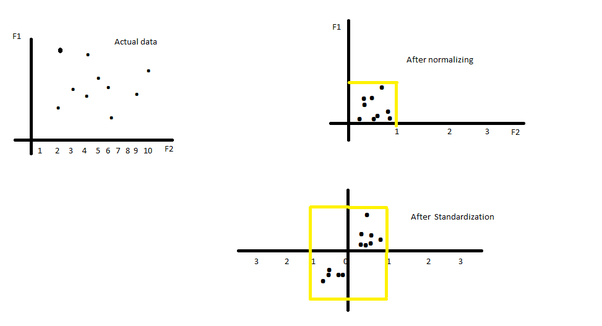

In [17]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model(To be replaced with ResNet50)
    # from keras.preprocessing import image

    # img = image.load_img(image_path, target_size=(299, 299))
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    # from keras.applications.inception_v3 import preprocess_input
    # from keras.applications.resnet50 import preprocess_input 
    x = preprocess_input(x)
    return x

###### Encoder Model Architecture

In [18]:
if HYP_ENCODER_MODEL == "RESNET50":
    model = ResNet50(weights='imagenet')

elif HYP_ENCODER_MODEL == "VGG16":
    model = VGG16(include_top=False, weights='imagenet')

    
elif HYP_ENCODER_MODEL == "INCEPTIONV3":
    model = InceptionV3(include_top=False, weights='imagenet')

else:
    print("Invalid HYP_ENCODER_MODEL")

102981632/102967424 [==============================] - 2s 0us/step


In [19]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
if HYP_ENCODER_MODEL == "RESNET50":
    # Create a new model, by removing the last layer (output layer) from the ResNet50
    model_new = Model(model.input, model.layers[-2].output)

elif HYP_ENCODER_MODEL == "VGG16":
    model_new = Model(model.input, model.layers[-1].output)
    
elif HYP_ENCODER_MODEL == "INCEPTIONV3":
    model_new = Model(model.input, model.layers[-1].output)

else:
    print("Invalid HYP_ENCODER_MODEL")




#What is the output of the model here
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
len(model.layers)

177

In [22]:
len(model_new.layers)

176

In [23]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image - user defined method
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [24]:
encode(train_img[0])
# train_img[0]

array([0.18960354, 1.0087956 , 0.5338026 , ..., 2.08207   , 0.17932509,
       0.04667779], dtype=float32)

###### Get feature vectors for **train images**

In [25]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 338.56745076179504


In [26]:
key1, val1 = list(encoding_train.items())[0]
type(encoding_train), len(encoding_train.keys())


(dict, 6000)

In [27]:
val1.shape

(2048,)

###### Get feature vectors for **test images**

In [28]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 56.51330256462097


In [29]:
key1, val1 = list(encoding_train.items())[0]
type(encoding_train), len(encoding_train.keys()), val1.shape


(dict, 6000, (2048,))

##### Dump the feature vectors of train and test images into a file using pickle mechanism

In [30]:
!mkdir "/content/sample_data/Pickle"
pkl_train_file="/content/sample_data/Pickle/encoded_train_images.pkl"
pkl_test_file = "/content/sample_data/Pickle/encoded_test_images.pkl"

In [31]:
# Save the bottleneck train features to disk
with open(pkl_train_file, "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [32]:

# Save the bottleneck test features to disk
with open(pkl_test_file, "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

#### Text Preprocessor


###### Loading the text from given dataset into workspace

In [33]:
if HYP_SOURCE_DATA_SET == "F8K":
    filename = "/content/Flickr8k.token.txt"

elif HYP_SOURCE_DATA_SET == "F30K":
    filename = "/content/Flickr8k.token.txt"

elif HYP_SOURCE_DATA_SET == "COCO123K":
    filename = "/content/Flickr8k.token.txt"

else:
    print("Invalid HYP_SOURCE_DATA_SET")

In [34]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [35]:

# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [36]:
# Prepare a dict of Image key and image specific descriptions

def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping


In [37]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [38]:
type(descriptions), list(descriptions.items())[0]

(dict,
 ('1000268201_693b08cb0e',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .']))

In [39]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [40]:
descriptions['10815824_2997e03d76'][2]

"A girl holding a horse 's lead behind a fire ."

###### Clean up the text

In [41]:
# prepare translation table for removing punctuation
# tokenize
# convert to lower case
# remove punctuation from each token
# remove hanging 's' and 'a'
# remove tokens with numbers in them
# store as string


def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)


In [42]:

# clean descriptions
clean_descriptions(descriptions)

In [43]:
descriptions['10815824_2997e03d76'][2]


'girl holding horse lead behind fire'

###### Prepare vocabulary of words

In [44]:
# convert the loaded descriptions into a vocabulary of words - vow
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc


In [45]:

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [46]:
type(vocabulary), list(vocabulary)[:5]

(set, ['chemical', 'motorists', 'extreme', 'rappeling', 'area'])

###### Dump / Write all the descriptions into a file
- [image1] [description1]
- [image2] [description2]
- [image3] [description3]

In [47]:

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [48]:

save_descriptions(descriptions, 'descriptions.txt')


## Train and test data sets


#### Images

In [49]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)


In [50]:
# load training dataset (6K)
train = load_set(train_images_file)
print('Dataset: %d' % len(train))

Dataset: 6000


In [51]:
list(train)[:5]

['1290894194_8a4ffdc7eb',
 '1837976956_3c45d0f9b8',
 '2205336881_d9ee4179d3',
 '2452334314_a7c443a787',
 '118309463_a532b75be9']

In [52]:
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [53]:
type(img), img[:5]

(list,
 ['/content/Flicker8k_Dataset/3178489390_13a6ae7524.jpg',
  '/content/Flicker8k_Dataset/3484019369_354e0b88c0.jpg',
  '/content/Flicker8k_Dataset/278007543_99f5a91a3e.jpg',
  '/content/Flicker8k_Dataset/3338217927_3c5cf3f7c6.jpg',
  '/content/Flicker8k_Dataset/1187593464_ce862352c6.jpg'])

In [54]:

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [55]:

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

#### Descriptions

In [56]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions


In [57]:
type(train), len(train), list(train)[:5]


(set,
 6000,
 ['1290894194_8a4ffdc7eb',
  '1837976956_3c45d0f9b8',
  '2205336881_d9ee4179d3',
  '2452334314_a7c443a787',
  '118309463_a532b75be9'])

In [58]:

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [59]:
list(train_descriptions.items())[0]

('1000268201_693b08cb0e',
 ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'])

In [60]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
    # if True:
        # break
len(all_train_captions) #, all_train_captions

30000

In [61]:
#To Check if there are any duplicate captions in train description. there are 232 duplicate entries
type(all_train_captions), len(all_train_captions), len(set(all_train_captions)), len(all_train_captions) - len(set(all_train_captions)) 

(list, 30000, 29768, 232)

In [62]:
# Prepare dataset for test dataset

###### Load all the captions and prepare 
1.   word_dict
2.   ixtoword
3.   wordtoix

In [63]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words [Actual words] %d -> [Words which are having >= 10 threshold] %d' % (len(word_counts), len(vocab)))

preprocessed words [Actual words] 7578 -> [Words which are having >= 10 threshold] 1651


In [64]:
vocab[:5]

['startseq', 'child', 'in', 'pink', 'dress']

In [65]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [66]:
list(wordtoix.items())[:5], list(ixtoword.items())[:5]

([('startseq', 1), ('child', 2), ('in', 3), ('pink', 4), ('dress', 5)],
 [(1, 'startseq'), (2, 'child'), (3, 'in'), (4, 'pink'), (5, 'dress')])

In [67]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

###### Find max length of the word from the descriptions

In [68]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)


In [69]:

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


#### Download Glove data set and load the content into workspace
GloVe - is an unsupervised learning algorithm for obtaining vector representations for words.


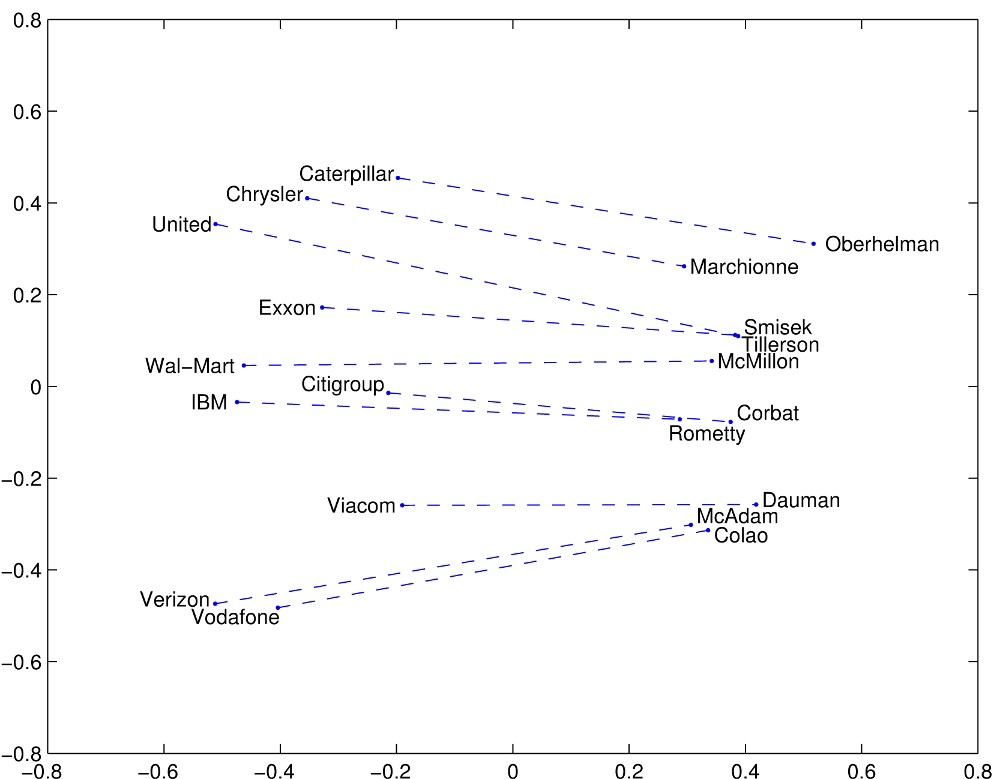

In [70]:
if HYP_DOWNLOAD_DATASET:
    if HYP_WORD_EMBEDDING == "GLOVE":
        !wget http://nlp.stanford.edu/data/glove.6B.zip
        !unzip glove*.zip
        # !wget http://nlp.stanford.edu/data/glove.6B.200d.zip
        # !unzip glove.6B.200d.zip

    elif HYP_WORD_EMBEDDING == "WORD2VEC":
        pass

    else:
        print("Invalid HYP_WORD_EMBEDDING")

--2022-08-13 17:53:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-13 17:53:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-13 17:53:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [71]:
if HYP_WORD_EMBEDDING == "GLOVE":
    # Load Glove vectors
    glove_dir = '/content/'
    embeddings_index = {} # empty dictionary

    f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

elif HYP_WORD_EMBEDDING == "WORD2VEC":
    pass

else:
    print("Invalid HYP_WORD_EMBEDDING")

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [72]:
type(embeddings_index), embeddings_index['feel'].shape, embeddings_index['feel'][:10]

(dict,
 (200,),
 array([ 0.28771 ,  0.064966, -0.20529 , -0.10327 , -0.075605, -0.13953 ,
        -0.31555 ,  0.20159 ,  0.2793  ,  0.51803 ], dtype=float32))

#### Get feature vectors for required words

In [73]:

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
missing_word_list = list()

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
    else:
        missing_word_list.append(word)

In [74]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.49340001, -0.0085568 , -0.4605    , ..., -0.55435002,
        -0.57477999, -0.013045  ],
       ...,
       [-0.021736  ,  0.15308   ,  0.11436   , ...,  0.078342  ,
        -0.39166999,  0.12937   ],
       [ 0.20298   , -0.10048   , -0.33627   , ...,  0.40496999,
        -0.19888   , -0.10866   ],
       [ 0.41156   , -0.25863001,  0.016209  , ..., -0.25419   ,
        -0.27496001,  0.67840999]])

In [75]:
if HYP_ENABLE_TRACE:
    embedding_matrix_tmp = np.zeros((vocab_size, 10))
    print(embedding_matrix_tmp.shape)
    print(embedding_matrix_tmp[:10])

In [76]:
missing_word_count=0
for each in embedding_matrix:
    if not all(each):
        # print(each)
        missing_word_count += 1

print("number of words missed: %s" % missing_word_count)

number of words missed: 10


In [77]:
missing_word_list

['startseq',
 'endseq',
 'snowcovered',
 'tshirt',
 'waterskier',
 'floaties',
 'upsidedown',
 'merrygoround',
 'rollerblader']

## LSTM Network


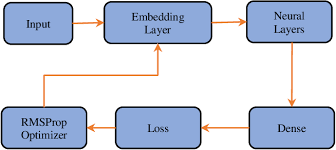

### Model architecture

###### SKIP EXECUTION - Trace - Decoder with LSTM

In [78]:
if HYP_ENABLE_TRACE:
    tmp_inputs1 = Input(shape=(2048,)) 
    tmp_inputs1.shape, tmp_inputs1

#### model without attention


In [79]:
if not HYP_ENABLE_ATTENTION:
    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    # [1,0,0,0,1,1,0,0,1]

    inputs2 = Input(shape=(max_length,)) #max_length = 34
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 8762
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])

    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

##### Plot with out attention

In [80]:
# from tensorflow.keras.utils import plot_model
# plot_model(lstm_model, "my_first_model.png", show_shapes=True, show_dtype=True,\
#            show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96, \
#            layer_range=None, show_layer_activations=True)

#### Model with Attention


###### SKIP EXECUTION - Attention architecture - BahdanauAttention - Try-Error

In [81]:
import tensorflow as tf

class BahdanauAttention(tf.keras.layers.Layer): # extending Layer(for building the architeccture in the form of layers) vs Model (to build a model)
  def __init__(self, units, verbose=0):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)
    self.verbose= verbose

  def call(self, query, values): 
    """
    query: features vectory
    values: hidden
    """

    if self.verbose:
      print('\n******* Bahdanau Attention STARTS******')
      print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
      print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1) # For converting (2048,) ==> (2048,1) 

    # query vs values input to the expand dims
    
    if self.verbose:
      print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    #values_with_time_axis

 
    if self.verbose:
      print('score: (batch_size, max_length, 1) ',score.shape)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    if self.verbose:
      print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    
    context_vector = attention_weights * values
    #  attention_weights * query
    
    if self.verbose:
      print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)

    context_vector = tf.reduce_sum(context_vector, axis=1)

    if self.verbose:
      print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
      print('\n******* Bahdanau Attention ENDS******')
      
    return context_vector, attention_weights


###### SKIP EXECUTION - Scrap 

In [82]:
if HYP_ENABLE_TRACE:
    #CNN_Encoder()
    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    # fe2 is features of the image from the encoder()
    # [1,0,0,0,1,1,0,0,1]

    #Attention
    #BahdanauAttention(units, verbose=0)
    # attention = BahdanauAttention(256, verbose=0)

In [83]:
if HYP_ENABLE_TRACE:
    fe2

In [84]:
if HYP_ENABLE_TRACE:
    embedding_dim

In [85]:
if not HYP_ENABLE_ATTENTION:
    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    # [1,0,0,0,1,1,0,0,1]

    inputs2 = Input(shape=(max_length,)) #max_length = 34
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 8762
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    #
    decoder1 = add([fe2, se3])

    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

##### Attention Architecture

build()

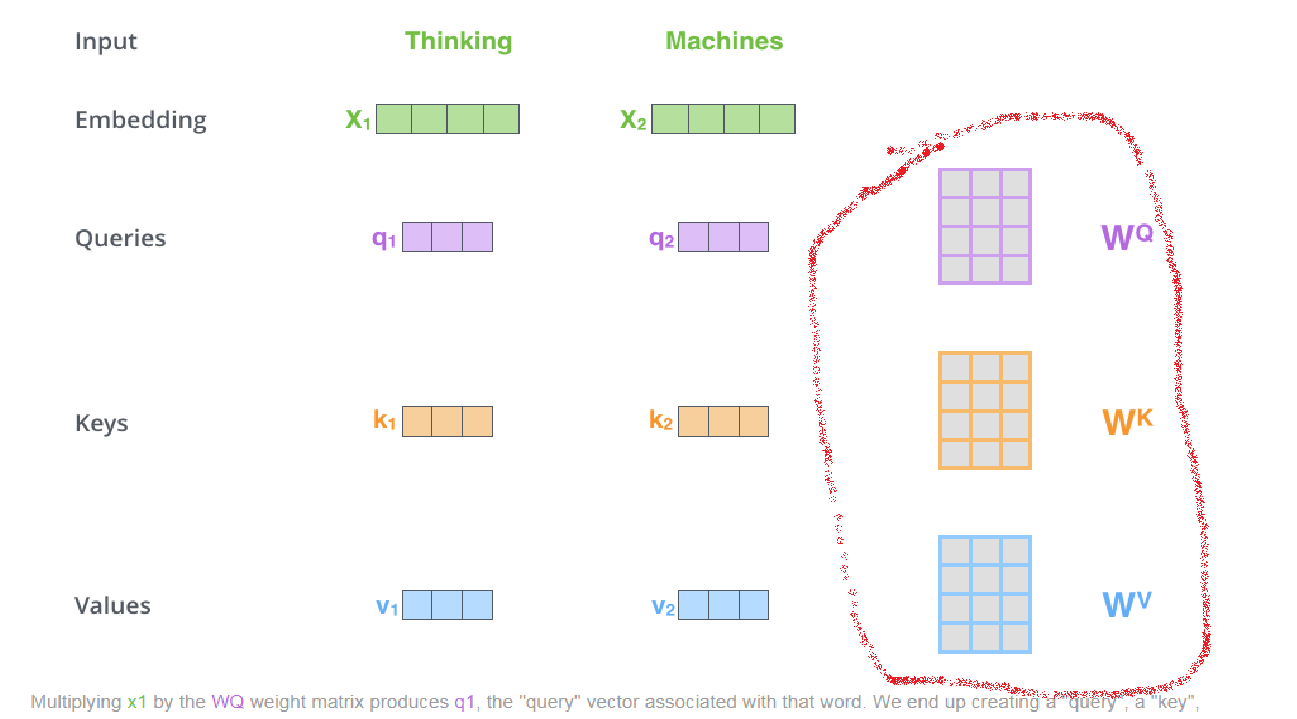

Call()

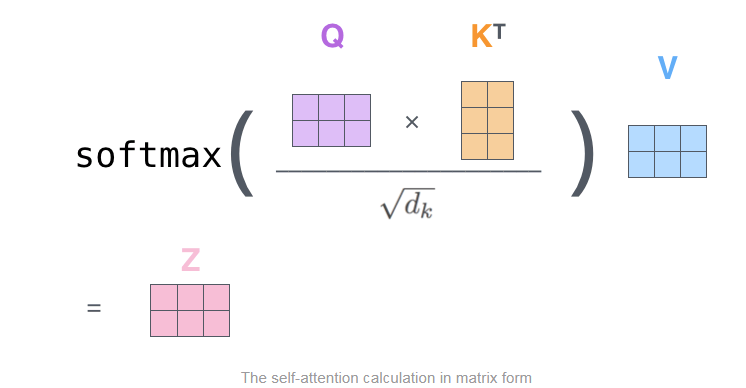

In [86]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

##### Embedding Attention and creating a model

In [87]:
features = 2048

vocab_size, features

(1652, 2048)

In [88]:
embedding_dim

200

In [89]:
# Reference: https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/

if HYP_ENABLE_ATTENTION:

    inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    inputs2 = Input(shape=(34,))
    # inputs=Input((features,))
    #embedding_dim - replace at output_dim
    # x=Embedding(input_dim=vocab_size, output_dim=200, input_length=features, embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)
    x = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 8762

    #se3 = LSTM(256)(se2)
    att_in=LSTM(256,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)

    att_out=attention()(att_in)

    decoder1 = add([fe2, att_out])

    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# outputs=Dense(1,activation='sigmoid',trainable=True)(att_out)

# model=Model(inputs1,outputs)


In [90]:
lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

##### Plot the model

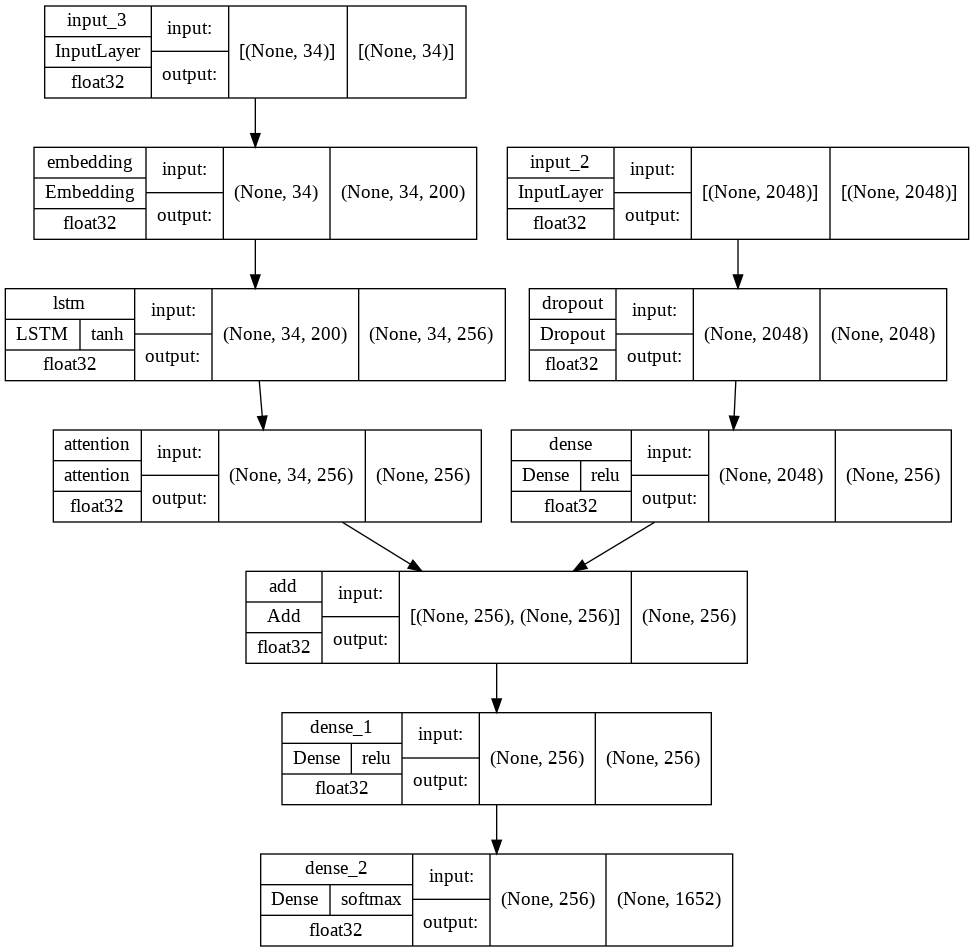

In [91]:

plot_model(lstm_model, "my_first_model.png", show_shapes=True, show_dtype=True,\
           show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96, \
           layer_range=None, show_layer_activations=True)

##### Compile model and set parameters

In [92]:
lstm_model.compile(loss=HYP_DECODER_LOSS, optimizer=HYP_DECODER_OPTIMIZER)

In [93]:
epochs = HYP_EPOCH
number_pics_per_bath = HYP_NO_OF_PICS_PER_BATCH
steps = len(train_descriptions)//number_pics_per_bath

In [94]:
steps

200

###### SKIP EXECUTION - temp scrap

In [95]:
if HYP_ENABLE_TRACE:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model.fit(x=train_x,y=train_y,batch_size=100,epochs=3,verbose=1,shuffle=True,validation_split=0.2)

In [96]:
if HYP_ENABLE_TRACE:
    # inputs1 = Input(shape=(2048,)) #2048 is the output of the RESNET50
    # fe1 = Dropout(0.5)(inputs1) # Dropping off 50% from the input - 1024
    # fe2 = Dense(256, activation='relu')(fe1) #relu 0 if <0.5 and 1 if >=0.5

    # [1,0,0,0,1,1,0,0,1]

    units = 512
    # embedding_dim = 200 #256 # 200
    #  vocab_size = 1652

    # decoder(dec_input, features, hidden)

    inputs2 = Input(shape=(max_length,)) #max_length = 34

    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) # embedding_dim = 200, vocab_size = 1652 # units = 512

    gru1 = tf.keras.layer.GRU(units, return_sequence=True, return_state=True, recurrent_initializer='glorot_uniform')

    fc1 = Dense(units)
    fc2 = Dense(vocab_size)

    attention = BahdanauAttention(units, verbose=1)
    
    # call(self, x=dec_input, features=fe2, hidden):
    #   dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)
    context_vector, attention_weights = attention(units)
    # se2 = Dropout(0.5)(se1)

    # se3 = LSTM(256)(se2)

    #decoder(dec_input, features, hidden)

In [97]:
if HYP_ENABLE_TRACE:
    context_vector, attention_weights = attention(fe2, se3)

In [98]:
if HYP_ENABLE_TRACE:
    attention_weights.shape, context_vector.shape, attention_weights.shape

In [99]:
if HYP_ENABLE_TRACE:
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # create attention object = 
    outputs, inputs1, inputs2

In [100]:
if HYP_ENABLE_TRACE:
    lstm_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # lstm_model = Model(inputs=[inputs1], outputs=outputs)

In [101]:
if HYP_ENABLE_TRACE:
    plot_model(lstm_model, "my_first_model.png", show_shapes=True, show_dtype=True,\
               show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96, \
               layer_range=None, show_layer_activations=True)

In [102]:
if HYP_ENABLE_TRACE:
    embedding_matrix.shape

In [103]:
if HYP_ENABLE_TRACE:
    attention_weights

In [104]:
if HYP_ENABLE_TRACE:
    lstm_model.layers[2].set_weights([embedding_matrix])
    lstm_model.layers[2].trainable = False

### Updating the lstm_model parameters


In [105]:
model.layers[2]

In [106]:
embedding_matrix.shape

(1652, 200)

In [107]:
lstm_model.layers[2].set_weights([embedding_matrix])
lstm_model.layers[2].trainable = False

## Training the model

#### Image / Description loader in the form of batches

###### data generator

In [108]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

###### SKIP EXECUTION - Try - Error

In [109]:
if HYP_ENABLE_TRACE:
    arrays = [np.random.randn(3, 4) for _ in range(10)]
    arrays
    np.stack(arrays, axis=0).shape

In [110]:
# There is an error, need to fix:
# ref: https://datascience.stackexchange.com/questions/103467/valueerror-layer-model-4-expects-1-inputs-but-it-received-10-input-tensors

In [111]:
if HYP_ENABLE_TRACE:
    for i in range(epochs):
        generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('./model_weights/model_' + str(i) + '.h5')

#### Fitting the lstm model without optimizer

In [112]:
train_features = load(open(pkl_train_file, "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [113]:
len(train_descriptions)

6000

In [114]:
# train_descriptions
# train_features
# wordtoix
# max_length 
# number_pics_per_bath

In [115]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    lstm_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    lstm_model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


200/200 [==============================] - 56s 280ms/step - loss: 4.0270


In [116]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    lstm_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    lstm_model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


200/200 [==============================] - 55s 276ms/step - loss: 3.1678


#### Fitting the lstm model with optimizer

In [117]:
lstm_model.optimizer.lr = HYP_DECODER_LEARNING_RATE
epochs = HYP_EPOCH
number_pics_per_bath = HYP_NO_OF_PICS_PER_BATCH
steps = len(train_descriptions)//number_pics_per_bath

In [118]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    lstm_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #lstm_model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


200/200 [==============================] - 55s 276ms/step - loss: 2.9992


#### Saving the model weights

In [119]:
lstm_model.save_weights('./model_weights/model_30.h5')

## Testing the model

Need to revisit this block

In [120]:
lstm_model.load_weights('./model_weights/model_30.h5')

In [121]:
with open(pkl_test_file, "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

## Caption Geneartion

In [122]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = lstm_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## User interface

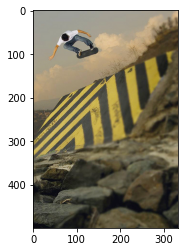

Greedy: person in yellow shirt is jumping over ramp


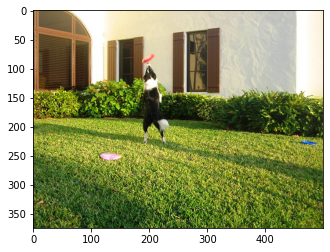

Greedy: dog in red shirt is jumping to catch ball


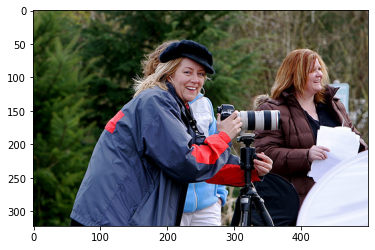

Greedy: two people are standing on the camera


In [127]:
for z in range(3):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image))

## Stats

In [124]:
print("************************* Hyper Parameters *************************")
print("HYP_SOURCE_DATA_SET = ", HYP_SOURCE_DATA_SET)
print("HYP_ENCODER_MODEL = ", HYP_ENCODER_MODEL)
print("HYP_WORD_EMBEDDING = ", HYP_WORD_EMBEDDING)
print("HYP_ENABLE_TRACE = ", HYP_ENABLE_TRACE)
print("HYP_ENABLE_ATTENTION = ", HYP_ENABLE_ATTENTION)
print("HYP_DECODER_LOSS = ", HYP_DECODER_LOSS)
print("HYP_DECODER_OPTIMIZER = ", HYP_DECODER_LOSS)
print("HYP_NO_OF_PICS_PER_BATCH = ", HYP_NO_OF_PICS_PER_BATCH)
print("HYP_EPOCH = ", HYP_EPOCH)
print("HYP_DECODER_LEARNING_RATE = ", HYP_DECODER_LEARNING_RATE)
print("\n\n\n")
print("************************* Observations *************************")
print("Train Accuracy = ")
print("Test Accuracy = ")
print("Bleu Metrics = ")

************************* Hyper Parameters *************************
HYP_SOURCE_DATA_SET =  F8K
HYP_ENCODER_MODEL =  RESNET50
HYP_WORD_EMBEDDING =  GLOVE
HYP_ENABLE_TRACE =  False
HYP_ENABLE_ATTENTION =  True
HYP_DECODER_LOSS =  categorical_crossentropy
HYP_DECODER_OPTIMIZER =  categorical_crossentropy
HYP_NO_OF_PICS_PER_BATCH =  30
HYP_EPOCH =  5
HYP_DECODER_LEARNING_RATE =  0.0001




************************* Observations *************************
Train Accuracy = 
Test Accuracy = 
Bleu Metrics = 
